# Quantitative Perspectives on Psychology
## Week 6 - Precision in prediction and assessment
### Example assessment exercises

We will focus on some relevant exercises that pull together the content from the previous chapters, leveraging all of the skills you have learned so far, and offer some challenges in terms of interpretation as well as coding.

## Starting off
As usual, import all the libraries and tools we've used so far, including things like the `rmse` function so we can check assumptions with GLMs.

In [1]:
# Your answer here
import pandas as pd
import pingouin as pg
import statsmodels.formula.api as smf
import seaborn as sns
import marginaleffects as me
import numpy as np
import statsmodels.tools.eval_measures as measures

sns.set_style('whitegrid')

# Case Study One
## Men's faces convey information about their bodies and their behavior - what you see is what you get
### Shoup & Gallup, 2008, Evolutionary Psychology
We will first consider this manuscript and its associated data. 

You can find the manuscript here, and I suggest giving it a read before beginning: https://journals.sagepub.com/doi/full/10.1177/147470490800600311
When you are ready, the data can be found here: https://vincentarelbundock.github.io/Rdatasets/csv/Stat2Data/Faces.csv

The paper reports a few correlations between its variables of shoulder to height ratio, number of sexual partners, facial attractiveness, and grip strength. Correlations alone are uninteresting, because they are not really a specified model, and they do not allow us to make claims about the influence of certain predictors while we hold others constant. 

The authors do report a regression model in the paper. Can you read in the data and fit this regression model (don't worry about the 'semi-partial' correlation content)?

### a. Fitting models

In [2]:
# Your answer here
# Read in data
faces = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/Stat2Data/Faces.csv')
display(faces.head())

# Fit the model as described
model = smf.ols('Attractive ~ SHR + MaxGripStrength + Partners', data=faces).fit()
model.summary(slim=True)

,rownames,MaxGripStrength,SHR,Partners,Attractive,AgeFirstSex
0,1,44.0,1.352,36,2.333,15.0
1,2,58.0,1.349,4,2.375,15.0
2,3,57.0,1.431,5,1.857,14.0
3,4,48.0,1.405,6,2.125,18.0
4,5,34.0,1.307,3,2.500,14.0


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Attractive   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.272
No. Observations:                  38   F-statistic:                     5.614
Covariance Type:            nonrobust   Prob (F-statistic):            0.00308
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.8901      0.996     -0.893      0.378      -2.915       1.135
SHR                 2.2248      0.797      2.790      0.009       0.604       3.845
MaxGripStrength     0.0059      0.011      0.545      0.590      -0.016       0.028
Partners            0.0188      0.012      1.590      0.121      -0.005       0.043
===================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

If you have successfully specified the model, you should see a similar set of coefficients as the 'B' reported in the paper. We can interpret this then as a one-unit increase in shoulder to hip ratio increasing attractiveness by 2.22 points. This is somewhat difficult to interpret though, as these particular variables (attractiveness and shoulder-hip ratio) are in rather abstract units (unlike grip strength and number of partners). Can you instead standardise all the values so that it recreates the 'β' coefficients, which represent changes in standard deviations?

In [3]:
# Your answer here
# Fit the model as described
model_s = smf.ols('scale(Attractive) ~ scale(SHR) + scale(MaxGripStrength) + scale(Partners)', data=faces).fit()
model_s.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      scale(Attractive)   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.272
No. Observations:                  38   F-statistic:                     5.614
Covariance Type:            nonrobust   Prob (F-statistic):            0.00308
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               5.796e-16      0.140   4.13e-15      1.000      -0.285       0.285
scale(SHR)                 0.4263      0.153      2.790      0.009       0.116       0.737
scale(MaxGripStrength)     0.0855      0.157      0.545      0.590      -0.233       0.404
scale(Partners)            0.2368      0.149      1.590      0.121      -0.066       0.540
==========================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

These two models are absolutely equivalent, we have just altered the meaning of the coefficients. If you have done this correctly and the values match, then you've just replicated an analysis in a published article. Well done!

### b. Model checking
Next, we should check the assumptions of:
- Linearity
- Homoscedasticity
- Normality of residuals

We can see each row belongs to only one male, so the independence assumption is fine. We will return to *validity* later. First, check the linearity assumption graphically by plotting the variables used in the regression against each other (can be done simply in `seaborn`).

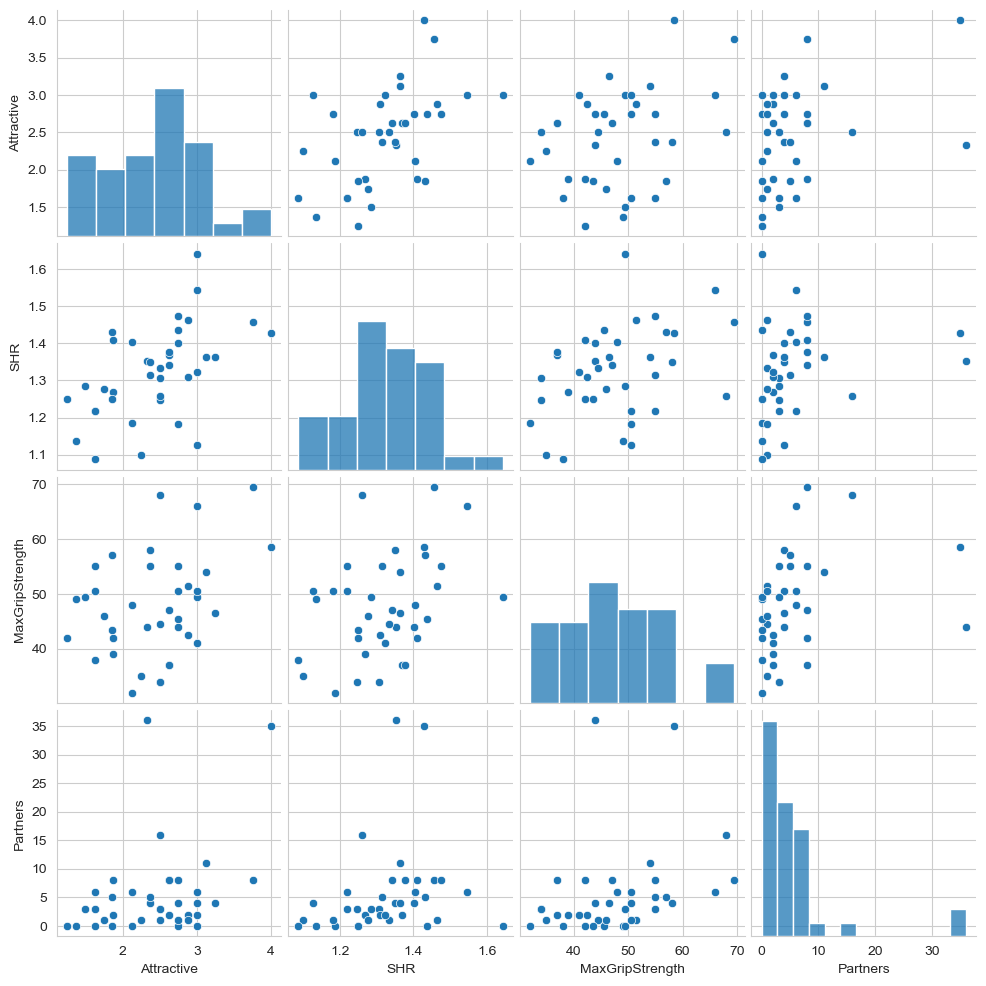

In [4]:
# Your answer here
sns.pairplot(faces[['Attractive', 'SHR', 'MaxGripStrength', 'Partners']])

Next, check the assumption of heteroscedasticity from the fitted model - you can use either instance you've made.

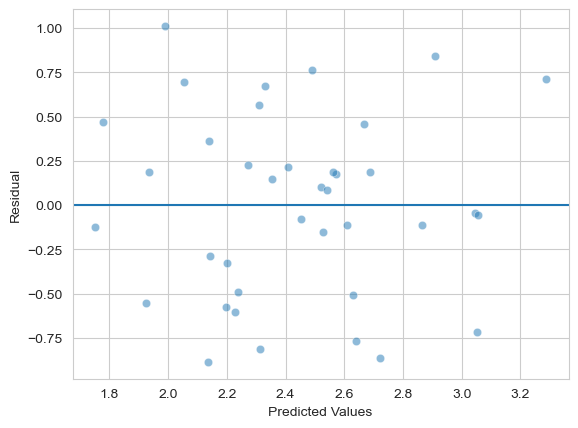

In [5]:
# Your answer here
axis = sns.scatterplot(x=model.fittedvalues, 
                       y=model.resid, alpha=.5) # scatter is easy
axis.set(xlabel='Predicted Values', ylabel='Residual') # Renaming 
axis.axhline(0) # Adding a horizontal line at zero

Finally, check the normality of residuals. You can do this graphically, and with a statistical test. Again, either model is fine. 

ShapiroResult(statistic=0.9684099822188909, pvalue=0.35074616263990327)

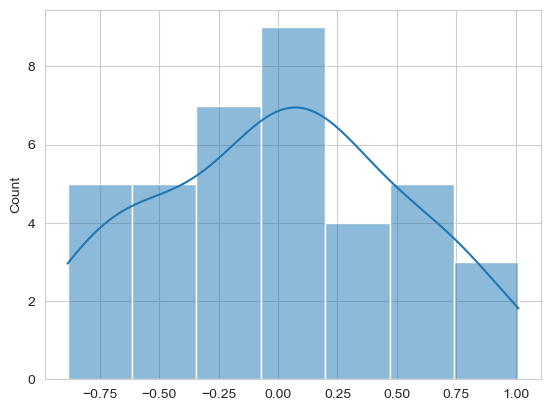

In [6]:
# Your answer here
sns.histplot(model.resid, kde=True)

from scipy.stats import shapiro
shapiro(model.resid)

In your view, are the assumptions all met? 

### c. Model evaluation
Before we interrogate the model further, the authors claim in the abstract good things about the variance explained by the model. We've seen how that isn't the best way to evaluate a model. Compute the RMSE for both your initial and second, standardised model to get a sense of how 'wrong' the model is.

Hint - for either model, you can access the dependent variable used via `your_model_variable.model.endog`. This is a copy of the data the model is trying to predict and can be handy in the use case of when you let the formula specification transform things.

In [7]:
# Your answer here
display(
    measures.rmse(model.model.endog,
                  model.fittedvalues),
    measures.rmse(model_s.model.endog,
                  model_s.fittedvalues)
)
    

0.5117926409212918

0.8177619301857805

One of your results will be for the non-standardised model, which tells you how wrong the model is, on average, in terms of 1-7 attractiveness rating scale points. The other result for the standardised model will be for the z-scored attractiveness rating scale.

In your view, is this a sufficiently accurate model? How wrong on average is it for raw scores and for standardised scores?

### d. Interpreting model predictions
Rather than focus on the coefficients, we will continue to interpret the predictions of this model, as we have done for many others.

Using the unstandardised model, consider tqo males.
- One has a SHR of 1, meaning his shoulders and waist are the same width entirely, like a barrel!
- One has a SHR of 1.25, his shoulders being 25% wider than his waist, approaching the inverted triangle shape.

For these tqo example males, we can consider them to have the full range of sexual partners and grip strength we see in the data, and we will average over those variables to obtain the marginal predictions of SHR. Can you create a datagrid that will produce this?

In [8]:
# Your answer here
dg = me.datagrid(model,
                 SHR=[1., 1.25],
                 MaxGripStrength=faces['MaxGripStrength'].unique(),
                 Partners=faces['Partners'].unique())

dg

SHR,MaxGripStrength,Partners,rownames,Attractive,AgeFirstSex
f64,f64,i64,i64,f64,f64
1.0,44.0,36,15,2.435447,16.16129
1.0,44.0,4,15,2.435447,16.16129
1.0,44.0,5,15,2.435447,16.16129
1.0,44.0,6,15,2.435447,16.16129
1.0,44.0,3,15,2.435447,16.16129
…,…,…,…,…,…
1.25,41.0,8,15,2.435447,16.16129
1.25,41.0,2,15,2.435447,16.16129
1.25,41.0,35,15,2.435447,16.16129


Once you have this, make the predictions for it, and average them by SHR, and plot the estimates. A big bonus if you can add the error bars as well.

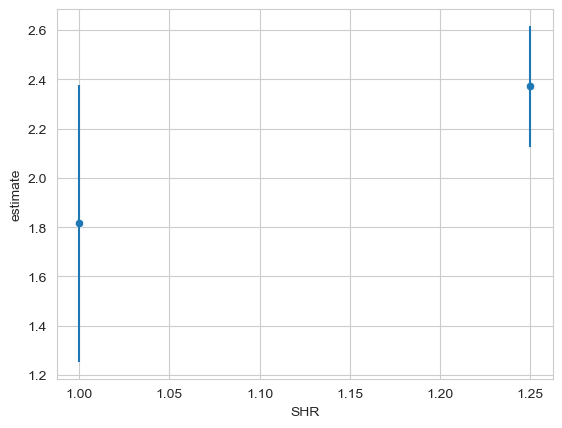

In [9]:
# Your answer here
p = me.predictions(model,
                   newdata=dg,
                   by='SHR')

# Plot
ax = sns.scatterplot(data=p, x='SHR', y='estimate')
ax.vlines(p['SHR'], p['conf_low'], p['conf_high'])

Now, conduct a null-hypothesis test of the differences between all three males - i.e. comparing all three males to each other. Are any more physically attractive than the rest?

In [10]:
# Your answer here
p = me.predictions(model,
                   newdata=dg,
                   by='SHR',
                   hypothesis='pairwise')
p

term,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high
str,f64,f64,f64,f64,f64,f64,f64
"""Row 1 - Row 2""",-0.556204,0.199335,-2.790292,0.005266,7.569062,-0.946895,-0.165514


The results indicate that the step up in SHR does indeed increase physical attractiveness, and the estimate is around 0.55 rating scale units. 

Consider that this null hypothesis of zero difference might not be very compelling. Let's instead test the hypothesis that the increase in SHR increases attractiveness by *at least* 0.20 rating scale units. 

In [11]:
# Your answer here
p = me.predictions(model,
                   newdata=dg,
                   by='SHR',
                   hypothesis='(b2-b1)=0.2')
p

term,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high
str,f64,f64,f64,f64,f64,f64,f64
"""(b2-b1)=0.2""",0.356204,0.199335,1.786958,0.073944,3.757419,-0.034486,0.746895


Does this increase in SHR alter attractiveness ratings by at *least* 0.2 rating scale units? Not quite, according to the model. 

### e. Model validity
So far we have seen that a step up from 1 to 1.25 SHR, averaged over sexual partners and hand grip strength, leads to an increase of about half a rating scale point. This difference is not significant when consdering an effect of about 0.2 units - whether or not that is a useful null hypothesis is of course a theoretical discussion, but it is worth considering.

There is one final, conceptual issue with the analysis as completed in the paper, and it is quite important from a theoretical perspective. 

Consider the structure of the model we have examined, and consider the introduction of the paper in terms of how it discusses the findings/theory.  Can you propose an alternative model that makes more sense? This is a difficult question, but take some time to consider.

In [12]:
# Your answer here
# The issue is that the authors talk about attractiveness predicting measures of strength/body size, and sexual behaviour.
# they use those measures to predict attractiveness, but this only partially makes sense. 
# How can number of sexual partners predict facial attractiveness, adjusted for other variables?
# this is like saying - having more sexual partners makes you better looking. 
# But its much more logical to consider that being better looking means you have more sexual partners.
# So the model is mis-specified; instead they should be predicting number of partners from the body traits.

If you've figured it out, can you fit the more theoretically correct model to the data?

In [13]:
# Your answer here
m3 = smf.ols('Partners ~ SHR + MaxGripStrength + Attractive', data=faces).fit()
m3.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Partners   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.102
No. Observations:                  38   F-statistic:                     2.400
Covariance Type:            nonrobust   Prob (F-statistic):             0.0849
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -11.9806     13.977     -0.857      0.397     -40.386      16.425
SHR                -0.6747     12.389     -0.054      0.957     -25.851      24.502
MaxGripStrength     0.1961      0.148      1.327      0.193      -0.104       0.497
Attractive          3.6876      2.319      1.590      0.121      -1.025       8.400
===================================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Case Study Two
## Women can judge sexual unfaithfulness from unfamiliar men's faces
### Rhodes, Morley, & Simmons, 2013
In the next study, we will examine the central claim from this manuscript. 

The manuscript is available from Canvas, and the data can be found here when you are ready: https://vincentarelbundock.github.io/Rdatasets/csv/Stat2Data/FaithfulFaces.csv

The first thing you might notice is that much of the analysis does not make sense! I agree. Unlike the first paper, to test the central claim here, we are going to have to do our own analysis. First, lets download the data, read it in, and print the top 10 and bottom 10 rows.

In [14]:
# Your answer here
faith = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/Stat2Data/FaithfulFaces.csv')

display(faith.head(), faith.tail())

,rownames,SexDimorph,Attract,Cheater,Trust,Faithful,FaceSex,RaterSex
0,1,4.900,2.000,1,4.118,6.294,F,M
1,2,2.583,2.083,1,4.000,6.588,F,M
2,3,4.300,2.667,1,3.941,5.824,F,M
3,4,4.083,2.917,0,4.118,5.412,F,M
4,5,4.500,3.500,0,3.235,4.000,F,M


,rownames,SexDimorph,Attract,Cheater,Trust,Faithful,FaceSex,RaterSex
165,166,3.833,4.167,0,5.294,5.471,M,F
166,167,3.083,2.583,1,5.294,5.824,M,F
167,168,5.250,2.917,0,3.000,3.824,M,F
168,169,4.750,2.333,0,3.000,3.824,M,F
169,170,5.167,3.833,0,2.941,3.353,M,F


The data contains a dichotomous variable, `Cheater` that codes whether the face belonged to someone who had admitted to infidelity. There are other variables such as `Trust` - how trustworthy that face appears, `Faithful` - ratings of faithfulness, `Attract` - how attractive the face was judged to be, and `RaterSex` - whether the face was rated by females or males. `FaceSex` is irrelevant because female participants rated only male faces and vice versa.

The specific claim here is that females can accurately perceive infidelity from men's faces, presumably via their ratings of faithfulness, and this is to be compared to males. 

Fit the appropriate model to the data that allows us to predict the `Cheater` variable from faithfulness and participant sex. This will need to test the difference between males and females and faithfulness ratings, so an interaction is needed (check 'model 1' in the paper for a clue).

Once done, print the summary.

In [15]:
# Your answer here
model = smf.probit('Cheater ~ Faithful * RaterSex', data=faith).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.596754
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:                Cheater   No. Observations:                  170
Model:                         Probit   Df Residuals:                      166
Method:                           MLE   Df Model:                            3
Date:                Fri, 30 Aug 2024   Pseudo R-squ.:                 0.01493
Time:                        21:15:15   Log-Likelihood:                -101.45
converged:                       True   LL-Null:                       -102.99
Covariance Type:            nonrobust   LLR p-value:                    0.3803
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.7160      0.729      0.982      0.326      -0.713       2.145
RaterSex[T.M]             -1.2827      1.276     -1.006      0.315      -3.783       1.217
Faithful                  -0.2597      0.153     -1.698      0.089      -0.559       0.040
Faithful:RaterSex[T.M]     0.2571      0.241      1.066      0.287      -0.216       0.730
==========================================================================================
"""

With the model fitted, make predictions for male and female raters, for faces of faithfulness ratings of 1 through to 9. Plot those outcomes.

<Axes: xlabel='Faithful', ylabel='estimate'>

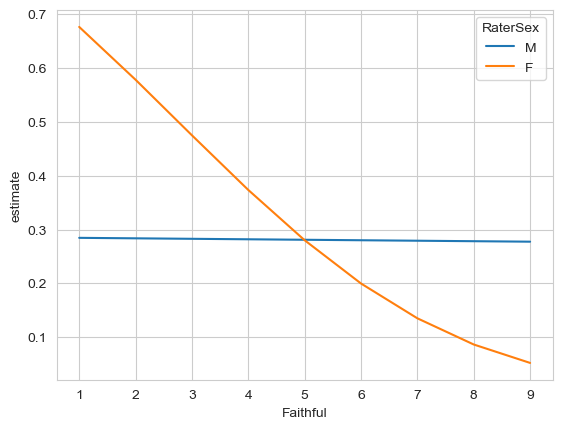

In [16]:
# Your answer here
dg = me.datagrid(model, 
                 RaterSex=['M', 'F'],
                 Faithful=np.arange(1, 10))

# Predict
p = me.predictions(model, newdata=dg)

# Plot
sns.lineplot(data=p,
             x='Faithful', 
             y='estimate',
             hue='RaterSex')

From examining the plot, what looks to be happening? Is the pattern at least from the plot similar to what the article claims?

In [17]:
# Your answer here
# Yes - it suggests that cheating accuracy is highest for females who make low faithfulness ratings. Males don't have any accuracy across the board.

Given the appearance of the plot, can we get an estimate of the slopes of both of the lines? This will tell us the unique relationship between faithfulness ratings for males and females.

In [18]:
# Your answer here
slopes = me.slopes(model,
                   newdata=dg,
                   variables='Faithful',
                   by='RaterSex')
slopes

RaterSex,term,contrast,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high
str,str,str,f64,f64,f64,f64,f64,f64,f64
"""F""","""Faithful""","""mean(dY/dX)""",-0.075793,0.031296,-2.421799,0.015444,6.016821,-0.137133,-0.014454
"""M""","""Faithful""","""mean(dY/dX)""",-0.00089,0.062949,-0.01414,0.988718,0.016369,-0.124267,0.122487


If you've successfully estimate the slopes, conduct a hypothesis test to see if they are statistically significantly different.

In [19]:
# Your answer here
me.slopes(model,
          newdata=dg,
          variables='Faithful',
          by='RaterSex',
          hypothesis='pairwise')

term,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high
str,f64,f64,f64,f64,f64,f64,f64
"""Row 1 - Row 2""",-0.074903,0.070291,-1.065619,0.286596,1.802909,-0.21267,0.062864


The answer appears to be incompatible with the claim of the manuscript.

Let us be at least charitable to the authors. Have the model make a prediction about the probability of a face being a cheater, given males and females rate it with a faithfulness of 1, the lowest possible rating. Is there a difference there?

In [20]:
# Your answer here
dg = me.datagrid(model,
                 RaterSex=['M', 'F'],
                 Faithful=[1])

# Predict
display(me.predictions(model, newdata=dg))

# Contrast
display(me.predictions(model, newdata=dg, hypothesis='b1=b2'))

RaterSex,Faithful,rowid,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high,rownames,SexDimorph,Attract,Cheater,Trust,FaceSex
str,i64,i32,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,i64,f64,str
"""M""",1,0,0.284553,0.292498,0.972837,0.330634,1.596691,-0.288732,0.857837,156,4.162171,2.9927,0,4.323206,"""M"""
"""F""",1,1,0.675911,0.208502,3.241746,0.001188,9.717251,0.267254,1.084567,156,4.162171,2.9927,0,4.323206,"""M"""


term,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high
str,f64,f64,f64,f64,f64,f64,f64
"""b1=b2""",-0.391358,0.359205,-1.089513,0.275928,1.857639,-1.095387,0.31267


Not even at the lowest level of accuracy is there a sex difference.

Repeat the predictions for males and females above, at the lowest level of faithfulness rating. Before taking the difference, set the null hypothesis to .50. This will tell us whether the predictions are actually better than chance or not. So now we are focusing not on the difference between males and females, but on the absolute probability their low faithfulness rating corresponds to a face that has actually cheated is better than a 50/50 coin flip.

In [21]:
# Your answer here
# Predict, just set hypothesis to .50
display(me.predictions(model, newdata=dg, hypothesis=.50))

RaterSex,Faithful,rowid,estimate,std_error,statistic,p_value,s_value,conf_low,conf_high,rownames,SexDimorph,Attract,Cheater,Trust,FaceSex
str,i64,i32,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,i64,f64,str
"""M""",1,0,0.284553,0.292498,-0.736579,0.461379,1.115977,-0.288732,0.857837,156,4.162171,2.9927,0,4.323206,"""M"""
"""F""",1,1,0.675911,0.208502,0.843689,0.398843,1.326105,0.267254,1.084567,156,4.162171,2.9927,0,4.323206,"""M"""


No luck there either!